In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xlsxwriter
from elasticsearch import Elasticsearch
from elasticsearch import helpers

In [12]:
df = pd.read_csv('byArticle-JSEN-201801-202309-New.csv', encoding='utf-8')

In [13]:
df = df.drop(['Rank', '1st Author Name', 'Volume Number', 'Issue Number', 'Content Type', 'Online Publish Year', 'Print Publish Year', 'Open Access', 'HTML Views', 'Total Usage', 'Author Keywords'], axis=1)

In [14]:
df['IEEE Thesaurus Terms'] = df['IEEE Thesaurus Terms'].str.replace(';', ' ')

In [15]:
es = Elasticsearch([{'host': 'localhost', 'port': 9200}])

index_settings = {
    "settings": {
        "analysis": {
            "analyzer": {
                "query_analyzer": {
                    "char_filter": [
                        "html_strip"
                    ],
                    "tokenizer": "standard",
                    "filter": [
                        "asciifolding",
                        "lowercase",
                        "stop",
                        "trim",
                        "keyword_repeat",
                        "stemmer",
                    ]
                }
            },
        }
    },
    "mappings": {
        "properties": {
            "article_number": {
                "type": "keyword"
            },
            "article_title": {
                "type": "text",
                "analyzer": "query_analyzer",
                "search_analyzer": "query_analyzer"
            },
            "doi": {
                "type": "keyword"
            },
            "ieee_thesaurus_terms": {
                "type": "text",
                "analyzer": "query_analyzer",
                "search_analyzer": "query_analyzer"
            },
            "pdf_downloads": {
                "type": "integer"
            },
            "paper_citations": {
                "type": "integer"
            },
            "patent_citations": {
                "type": "integer"
            },
            "total_citations": {
                "type": "integer"
            },
            "url": {
                "type": "keyword"
            },
        }
    }
}

if not es.indices.exists(index='ieee'):
    print("creating 'ieee' index...")
    res = es.indices.create(index='ieee', ignore=400, body=index_settings)
    print(res)
    print('Connected to the database')

creating 'ieee' index...
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'ieee'}
Connected to the database


In [16]:
topics = pd.read_excel('Sustainable Development Goals_Keywords.xlsx', sheet_name='Sheet1')

In [17]:
topics = topics.rename(columns={'Sustainable Development Goals': 'Goal', 'Unnamed: 1': 'Topic', 'Current Keywords (https://sustainability.utoronto.ca/inventories/sustainable-development-goals-sdgs-keywords/)': 'keywords'})

In [18]:
topics['keywords'] = topics['keywords'].str.replace(', ', ',')
topics['keywords'] = topics['keywords'].str.replace(' ', '_')
topics['keywords'] = topics['keywords'].str.replace(',', ' ')
topics['keywords'] = topics['keywords'].str.replace('-', '_')

topics['Original_Topic'] = topics['Topic']

topics['Topic'] = topics['Topic'].str.replace(' ', '_')
topics['Topic'] = topics['Topic'].str.replace('_&_', ' ')
topics['Topic'] = topics['Topic'].str.replace('-', '_')
topics['Topic'] = topics['Topic'].str.replace(',', '')

topics['Goal'] = topics['Goal'].str.replace('\u200b', '')
topics['Goal'] = topics['Goal'].str.strip()

In [19]:
df = df.astype(str)
df['PDF Downloads'] = df['PDF Downloads'].astype(int)
df['Paper Citations To Date'] = df['Paper Citations To Date'].astype(int)
df['Patent Citations To Date'] = df['Patent Citations To Date'].astype(int)
df['Total Citations To Date'] = df['Total Citations To Date'].astype(int)

In [20]:
for index, row in df.iterrows():
    es.index(index='ieee', doc_type='_doc', id=index, body={
        'article_number': row['Article Number'],
        'article_title': row['Article Title'],
        'doi': row['DOI'],
        'pdf_downloads': row['PDF Downloads'],
        'paper_citations': row['Paper Citations To Date'],
        'patent_citations': row['Patent Citations To Date'],
        'total_citations': row['Total Citations To Date'],
        'ieee_thesaurus_terms': row['IEEE Thesaurus Terms'],
        'url': row['URL']
    })

In [21]:
goal_map = {}
for index, row in topics.iterrows():
    goal_map[row['Goal']] = {}
    res = es.search(index='ieee', body={
        'query': {
            'bool': {
                'should': [
                    {
                        'match': {
                            'article_title': row['Topic']
                        }
                    },
                    {
                        'match': {
                            'ieee_thesaurus_terms': row['Topic']
                        }
                    },
                    {
                        'match': {
                            'article_title': row['keywords']
                        }
                    },
                    {
                        'match': {
                            'ieee_thesaurus_terms': row['keywords']
                        }
                    }
                ]
            }
        }
    }, size=10000)
    goal_map[row['Goal']] = res
    articles = []
    for hit in res['hits']['hits']:
        articles.append({
            'article_number': hit['_source']['article_number'],
            'article_title': hit['_source']['article_title'],
            'doi': hit['_source']['doi'],
            'ieee_thesaurus_terms': hit['_source']['ieee_thesaurus_terms'],
            'pdf_downloads': hit['_source']['pdf_downloads'],
            'paper_citations': hit['_source']['paper_citations'],
            'patent_citations': hit['_source']['patent_citations'],
            'total_citations': hit['_source']['total_citations'],
            'url': hit['_source']['url'],
            'score': hit['_score']
        })
    goal_map[row['Goal']] = {
        'total': len(articles),
        'topic': row['Original_Topic'],
        'keywords': row['keywords'],
        'articles': articles
    } 

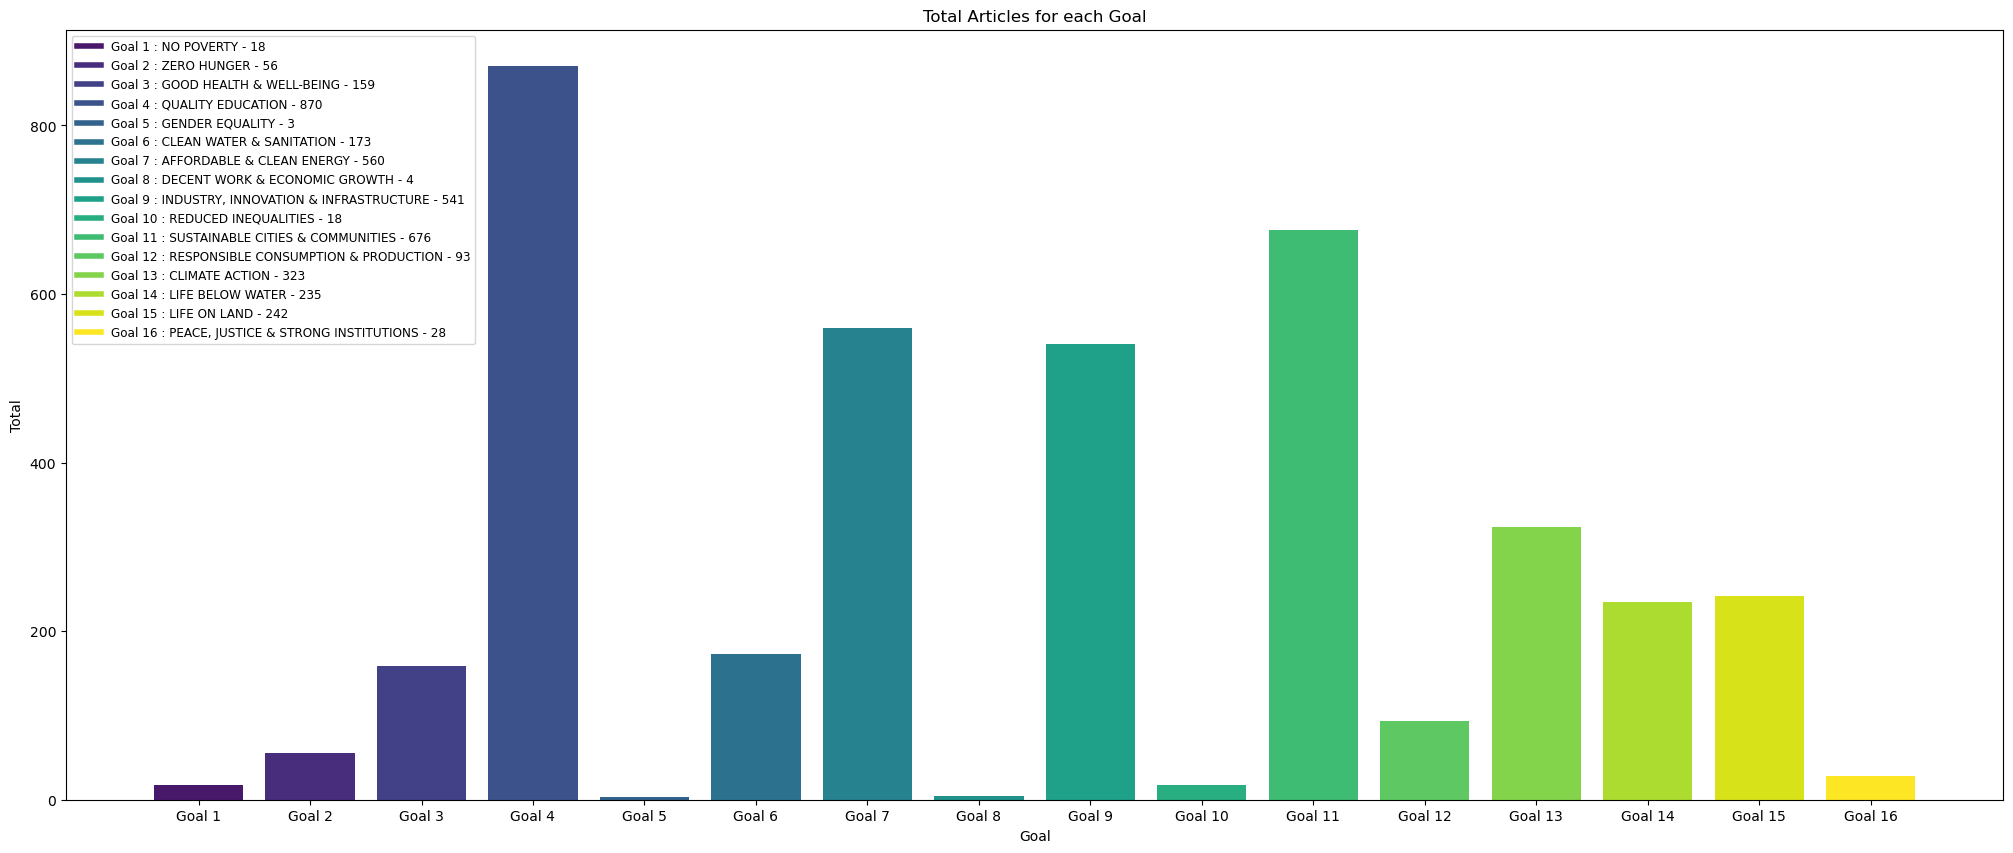

<Figure size 640x480 with 0 Axes>

In [22]:
plt.figure(figsize=(25, 10))

x = []
y = []
colors = [] 
labels = []
for key, value in goal_map.items():
    x.append(key)
    y.append(value['total'])
    labels.append(key + ' : ' + value['topic'] + ' - ' + str(value['total']))
    colors.append(plt.cm.viridis(len(labels) / len(goal_map)))

bars = plt.bar(x, y, color=colors)

legend_handles = []
for i, label in enumerate(labels):
    legend_handles.append(plt.Line2D([0], [0], color=colors[i], lw=4, label=label))

plt.legend(handles=legend_handles, loc='upper left', prop={'size': 8.7}, borderaxespad=0.5)
plt.xlabel('Goal')
plt.ylabel('Total')
plt.title('Total Articles for each Goal')
plt.show()

plt.savefig('bar_plot.png')

In [23]:
workbook = xlsxwriter.Workbook('goalwise_result.xlsx')
for key, value in goal_map.items():
    worksheet = workbook.add_worksheet(key)
    bold = workbook.add_format({'bold': True})
    worksheet.write('A1', key, bold)
    worksheet.write('A2', value['topic'], bold)
    worksheet.write('A3', 'Total : ' + str(value['total']), bold)
    worksheet.write('A5', 'Article Number', bold)
    worksheet.write('B5', 'Article Title', bold)
    worksheet.write('C5', 'Total Downloads', bold)
    worksheet.write('D5', 'Total Paper Citations', bold)
    worksheet.write('E5', 'Total Patent Citations', bold)
    worksheet.write('F5', 'Total Citations', bold)
    worksheet.write('G5', 'DOI', bold)
    worksheet.write('H5', 'IEEE Thesaurus Terms', bold)
    worksheet.write('I5', 'URL', bold)
    worksheet.write('J5', 'Score', bold)
    row = 6
    for article in value['articles']:
        worksheet.write('A' + str(row), article['article_number'])
        worksheet.write('B' + str(row), article['article_title'])
        worksheet.write('C' + str(row), article['pdf_downloads'])
        worksheet.write('D' + str(row), article['paper_citations'])
        worksheet.write('E' + str(row), article['patent_citations'])
        worksheet.write('F' + str(row), article['total_citations'])
        worksheet.write('G' + str(row), article['doi'])
        worksheet.write('H' + str(row), article['ieee_thesaurus_terms'])
        worksheet.write('I' + str(row), article['url'])
        worksheet.write('J' + str(row), article['score'])
        row += 1
workbook.close()

In [24]:
group_of_goals_map = {}

group_of_goals_map['Health'] = {}
group_of_goals_map['Health']['total'] = goal_map['Goal 3']['total']
group_of_goals_map['Health']['topic'] = 'Health'
group_of_goals_map['Health']['articles'] = goal_map['Goal 3']['articles']

group_of_goals_map['Smart Cities'] = {}
group_of_goals_map['Smart Cities']['total'] = goal_map['Goal 1']['total'] + goal_map['Goal 9']['total'] + goal_map['Goal 11']['total']
group_of_goals_map['Smart Cities']['topic'] = 'Smart Cities'
group_of_goals_map['Smart Cities']['articles'] = goal_map['Goal 1']['articles'] + goal_map['Goal 9']['articles'] + goal_map['Goal 11']['articles']

group_of_goals_map['Clean Environment'] = {}
group_of_goals_map['Clean Environment']['total'] = goal_map['Goal 6']['total'] + goal_map['Goal 7']['total'] + goal_map['Goal 14']['total'] + goal_map['Goal 15']['total']
group_of_goals_map['Clean Environment']['topic'] = 'Clean Environment'
group_of_goals_map['Clean Environment']['articles'] = goal_map['Goal 6']['articles'] + goal_map['Goal 7']['articles'] + goal_map['Goal 14']['articles'] + goal_map['Goal 15']['articles']

group_of_goals_map['Resource-friendly Growth'] = {}
group_of_goals_map['Resource-friendly Growth']['total'] = goal_map['Goal 2']['total'] + goal_map['Goal 8']['total'] + goal_map['Goal 11']['total'] + goal_map['Goal 12']['total'] + goal_map['Goal 13']['total']
group_of_goals_map['Resource-friendly Growth']['topic'] = 'Resource-friendly Growth'
group_of_goals_map['Resource-friendly Growth']['articles'] = goal_map['Goal 2']['articles'] + goal_map['Goal 8']['articles'] + goal_map['Goal 11']['articles'] + goal_map['Goal 12']['articles'] + goal_map['Goal 13']['articles']

group_of_goals_map['Women in Engineering'] = {}
group_of_goals_map['Women in Engineering']['total'] = goal_map['Goal 5']['total']
group_of_goals_map['Women in Engineering']['topic'] = 'Women in Engineering'
group_of_goals_map['Women in Engineering']['articles'] = goal_map['Goal 5']['articles']

group_of_goals_map['Geographic Action'] = {}
group_of_goals_map['Geographic Action']['total'] = goal_map['Goal 4']['total'] + goal_map['Goal 10']['total']
group_of_goals_map['Geographic Action']['topic'] = 'Geographic Action'
group_of_goals_map['Geographic Action']['articles'] = goal_map['Goal 4']['articles'] + goal_map['Goal 10']['articles']


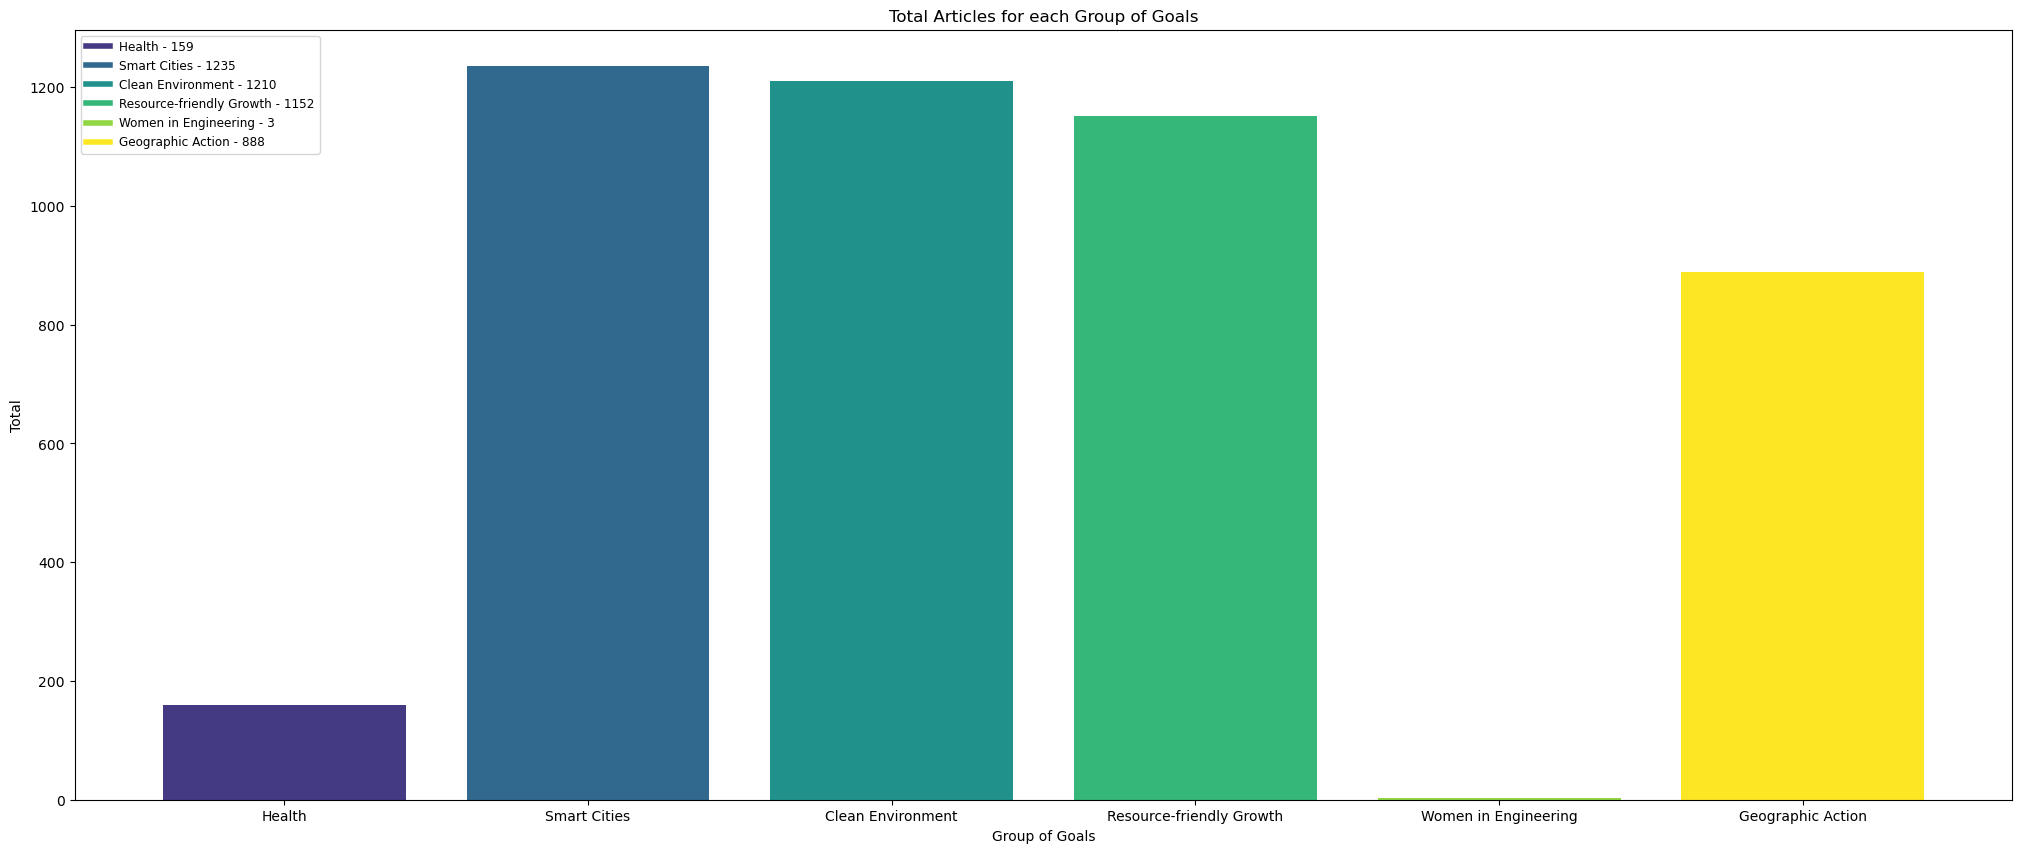

<Figure size 640x480 with 0 Axes>

In [25]:
plt.figure(figsize=(25, 10))

x = []
y = []
colors = [] 
labels = []
for key, value in group_of_goals_map.items():
    x.append(key)
    y.append(value['total'])
    labels.append(value['topic'] + ' - ' + str(value['total']))
    colors.append(plt.cm.viridis(len(labels) / len(group_of_goals_map)))

bars = plt.bar(x, y, color=colors)

legend_handles = []
for i, label in enumerate(labels):
    legend_handles.append(plt.Line2D([0], [0], color=colors[i], lw=4, label=label))

plt.legend(handles=legend_handles, loc='upper left', prop={'size': 8.7}, borderaxespad=0.5)
plt.xlabel('Group of Goals')
plt.ylabel('Total')
plt.title('Total Articles for each Group of Goals')
plt.show()

plt.savefig('group_bar_plot.png')

In [26]:
workbook = xlsxwriter.Workbook('groupwise_result.xlsx')
for key, value in group_of_goals_map.items():
    worksheet = workbook.add_worksheet(key)
    bold = workbook.add_format({'bold': True})
    worksheet.write('A1', key, bold)
    worksheet.write('A2', value['topic'], bold)
    worksheet.write('A3', 'Total : ' + str(value['total']), bold)
    worksheet.write('A5', 'Article Number', bold)
    worksheet.write('B5', 'Article Title', bold)
    worksheet.write('C5', 'Total Downloads', bold)
    worksheet.write('D5', 'Total Paper Citations', bold)
    worksheet.write('E5', 'Total Patent Citations', bold)
    worksheet.write('F5', 'Total Citations', bold)
    worksheet.write('G5', 'DOI', bold)
    worksheet.write('H5', 'IEEE Thesaurus Terms', bold)
    worksheet.write('I5', 'URL', bold)
    worksheet.write('J5', 'Score', bold)
    row = 6
    for article in value['articles']:
        worksheet.write('A' + str(row), article['article_number'])
        worksheet.write('B' + str(row), article['article_title'])
        worksheet.write('C' + str(row), article['pdf_downloads'])
        worksheet.write('D' + str(row), article['paper_citations'])
        worksheet.write('E' + str(row), article['patent_citations'])
        worksheet.write('F' + str(row), article['total_citations'])
        worksheet.write('G' + str(row), article['doi'])
        worksheet.write('H' + str(row), article['ieee_thesaurus_terms'])
        worksheet.write('I' + str(row), article['url'])
        worksheet.write('J' + str(row), article['score'])
        row += 1
workbook.close()